In [5]:
%matplotlib inline

In [6]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

In [7]:
#The first time this will download a dataset that is ~650mb
path = untar_data(URLs.ESC50) 

The audio files are inside a subfolder `audio/`

In [8]:
(path/"audio").ls()

(#2000) [Path('/home/scart/.fastai/data/master/audio/5-198891-A-8.wav'),Path('/home/scart/.fastai/data/master/audio/3-128512-A-47.wav'),Path('/home/scart/.fastai/data/master/audio/4-234879-A-6.wav'),Path('/home/scart/.fastai/data/master/audio/3-100024-A-27.wav'),Path('/home/scart/.fastai/data/master/audio/5-263831-A-6.wav'),Path('/home/scart/.fastai/data/master/audio/1-22804-A-46.wav'),Path('/home/scart/.fastai/data/master/audio/2-117615-A-48.wav'),Path('/home/scart/.fastai/data/master/audio/5-221518-A-21.wav'),Path('/home/scart/.fastai/data/master/audio/2-43802-A-42.wav'),Path('/home/scart/.fastai/data/master/audio/5-194899-D-3.wav')...]

And there's another folder `meta/` with some metadata about all the files and the labels

In [9]:
(path/"meta").ls()

(#2) [Path('/home/scart/.fastai/data/master/meta/esc50.csv'),Path('/home/scart/.fastai/data/master/meta/esc50-human.xlsx')]

Opening the metadata file

In [10]:
df = pd.read_csv(path/"meta"/"esc50.csv")
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Looking at the fold attribute, this dataset has a 5 fold cross validation setup

In [11]:
df["fold"].value_counts()

5    400
4    400
3    400
2    400
1    400
Name: fold, dtype: int64

## Datablock and Basic End to End Training on 10 Speakers

In [12]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [13]:
cfg = AudioConfig.BasicMelSpectrogram()
a2s = AudioToSpec.from_cfg(cfg)

In [14]:
def get_data(fold):
    auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                     get_x=ColReader("filename", pref=path/"audio"), 
                     splitter=CrossValidationSplitter(fold=fold),
                     batch_tfms = [a2s],
                     get_y=ColReader("category"))
    return auds.dataloaders(df, bs=64)

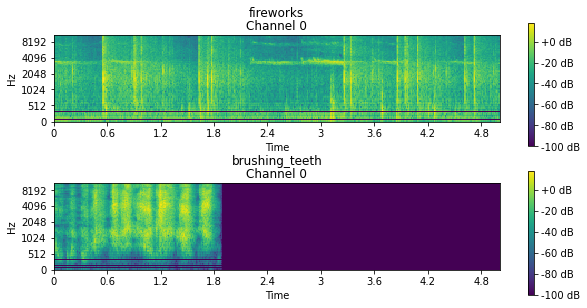

In [23]:
dbunch = get_data(fold=1)
dbunch.show_batch(figsize=(10, 5))

In [15]:
def get_learner(data):
    return cnn_learner(data, 
                    resnet18, 
                    config=cnn_config(n_in=1),
                    loss_fn=CrossEntropyLossFlat,
                    metrics=[accuracy]                 
                    )

# 10 epochs

In [16]:
accuracies = []

for i in range(1, 6):
    data = get_data(fold=i)
    learn = get_learner(data)
    learn.fit_one_cycle(10)
    accuracies.append(learn.recorder.values[-1][-1])

print(sum(accuracies) / 5)

epoch,train_loss,valid_loss,accuracy,time
0,5.419570,3.895160,0.060000,00:09
1,4.404723,2.431923,0.375000,00:08
2,3.257022,1.848340,0.515000,00:07
3,2.402743,1.605196,0.570000,00:07
4,1.821890,1.461367,0.615000,00:07
5,1.378323,1.385855,0.627500,00:07
6,1.059020,1.349235,0.632500,00:07
7,0.862736,1.323914,0.627500,00:08
8,0.722517,1.314126,0.620000,00:07
9,0.635301,1.314258,0.632500,00:07


epoch,train_loss,valid_loss,accuracy,time
0,5.536232,3.954023,0.062500,00:07
1,4.509410,2.463781,0.352500,00:07
2,3.326658,1.799773,0.485000,00:07
3,2.429335,1.574403,0.540000,00:07
4,1.814522,1.424541,0.597500,00:07
5,1.394910,1.370052,0.622500,00:07
6,1.079782,1.306877,0.652500,00:07
7,0.863269,1.275747,0.637500,00:07
8,0.725081,1.250945,0.660000,00:07
9,0.619892,1.261818,0.642500,00:07


epoch,train_loss,valid_loss,accuracy,time
0,5.393421,3.932143,0.067500,00:07
1,4.415945,2.321761,0.405000,00:07
2,3.247215,1.716711,0.502500,00:07
3,2.398611,1.478829,0.582500,00:07
4,1.780957,1.384821,0.600000,00:07
5,1.364695,1.310773,0.607500,00:07
6,1.061540,1.264345,0.620000,00:07
7,0.836238,1.234012,0.620000,00:07
8,0.690911,1.224793,0.627500,00:07
9,0.596977,1.221690,0.640000,00:07


epoch,train_loss,valid_loss,accuracy,time
0,5.399308,3.855129,0.110000,00:07
1,4.416417,2.274144,0.387500,00:07
2,3.282470,1.632455,0.520000,00:07
3,2.434038,1.384499,0.597500,00:07
4,1.811319,1.279789,0.625000,00:07
5,1.399508,1.211795,0.655000,00:07
6,1.087370,1.157081,0.665000,00:07
7,0.867883,1.120747,0.672500,00:07
8,0.721416,1.113729,0.677500,00:08
9,0.642558,1.112384,0.677500,00:07


epoch,train_loss,valid_loss,accuracy,time
0,5.468500,3.869771,0.085000,00:07
1,4.414398,2.335774,0.380000,00:07
2,3.240930,1.755011,0.532500,00:07
3,2.363889,1.518698,0.572500,00:07
4,1.765931,1.421772,0.602500,00:07
5,1.350982,1.351093,0.627500,00:07
6,1.044850,1.304194,0.635000,00:07
7,0.849740,1.285063,0.650000,00:07
8,0.687561,1.268005,0.657500,00:07
9,0.598775,1.273774,0.655000,00:07


0.6494999885559082


# 20 epochs

In [17]:
accuracies = []

for i in range(1, 6):
    data = get_data(fold=i)
    learn = get_learner(data)
    learn.fit_one_cycle(20)
    accuracies.append(learn.recorder.values[-1][-1])

print(sum(accuracies) / 5)

epoch,train_loss,valid_loss,accuracy,time
0,5.510909,4.224758,0.042500,00:09
1,4.965037,3.343655,0.155000,00:09
2,4.121314,2.400854,0.340000,00:08
3,3.190613,1.914033,0.465000,00:07
4,2.425727,1.693172,0.517500,00:07
5,1.831763,1.582514,0.562500,00:08
6,1.391560,1.439342,0.595000,00:08
7,1.061687,1.350717,0.617500,00:07
8,0.813821,1.358099,0.625000,00:07
9,0.653208,1.345876,0.635000,00:08


epoch,train_loss,valid_loss,accuracy,time
0,5.523293,4.172580,0.047500,00:07
1,4.998077,3.296689,0.187500,00:07
2,4.125558,2.349253,0.385000,00:07
3,3.231952,1.828578,0.530000,00:07
4,2.484842,1.567219,0.557500,00:07
5,1.891965,1.407712,0.572500,00:08
6,1.430011,1.336543,0.622500,00:07
7,1.098856,1.311591,0.652500,00:08
8,0.854059,1.282096,0.627500,00:07
9,0.670720,1.235163,0.632500,00:08


epoch,train_loss,valid_loss,accuracy,time
0,5.528911,4.328894,0.017500,00:06
1,5.020090,3.392097,0.155000,00:05
2,4.148098,2.472698,0.372500,00:05
3,3.243588,1.916046,0.500000,00:05
4,2.486919,1.643157,0.552500,00:05
5,1.863217,1.520090,0.570000,00:05
6,1.410313,1.427645,0.585000,00:05
7,1.077070,1.394796,0.610000,00:05
8,0.843955,1.307168,0.617500,00:05
9,0.671334,1.301868,0.635000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,5.529652,4.142406,0.050000,00:05
1,5.000852,3.204163,0.205000,00:05
2,4.151220,2.222000,0.375000,00:05
3,3.238881,1.689687,0.502500,00:05
4,2.452410,1.417095,0.560000,00:05
5,1.858986,1.285477,0.642500,00:05
6,1.413481,1.208131,0.637500,00:05
7,1.100693,1.121226,0.657500,00:05
8,0.861923,1.109481,0.660000,00:05
9,0.679850,1.041177,0.667500,00:05


epoch,train_loss,valid_loss,accuracy,time
0,5.580701,4.306807,0.037500,00:05
1,5.036737,3.372760,0.185000,00:05
2,4.188970,2.459674,0.357500,00:05
3,3.282065,1.878978,0.500000,00:05
4,2.500230,1.657684,0.542500,00:05
5,1.896449,1.482798,0.570000,00:05
6,1.441881,1.407925,0.595000,00:05
7,1.113786,1.360703,0.602500,00:05
8,0.869283,1.297951,0.632500,00:05
9,0.675438,1.303653,0.655000,00:05


0.6735000014305115
